The notebook below imports the RSI's Confirmation Hearings dataset and runs some quick cleansing, reshaping, and plotting functions. 

In [68]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.corpus import stopwords
import warnings
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
stopword_list = nltk.corpus.stopwords.words('english')

In [2]:
#Load in the hearing data. Note that I have renamed the columns to be a bit easier to work with.

dataframe = pd.read_excel('confirmation_hearings.xlsx')
dataframe.columns = ['Total Order', 'Order', 'Year', 'Hearing', 'Title', 'Party', 'Speaker', 'Statements']

In [74]:
#One of the quirks of this dataset is that the "Statement" column always begins with the name of the speaker.
#This can make it challenging to query specific speakers, so I've built a small function to remove them.
def remove_speaker_headers(text):
    try:
        text = text.split('.', 1)[1]
    except:
        pass
    return text

sid = SentimentIntensityAnalyzer()

#Calculates a basic sentiment (polarity) for the overall statement.
def calculate_sentiment(text):
    ss = sid.polarity_scores(text)
    sentiment = ss['compound']
    return sentiment

#Uses the NLTK word tokenizer to calculate the number of words in a statement.
def get_word_count(text):
    word_count = word_tokenize(text)
    return len(word_count)

#Converts sentences into word tokens
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

#Removes junk words from the corpus
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [4]:
#Run the above functions on the original dataframe.
dataframe['Statements'] = map(remove_speaker_headers, dataframe['Statements'])
dataframe['Sentiment'] = map(calculate_sentiment, dataframe['Statements'])
dataframe['word_count'] = map(get_word_count, dataframe['Statements'])

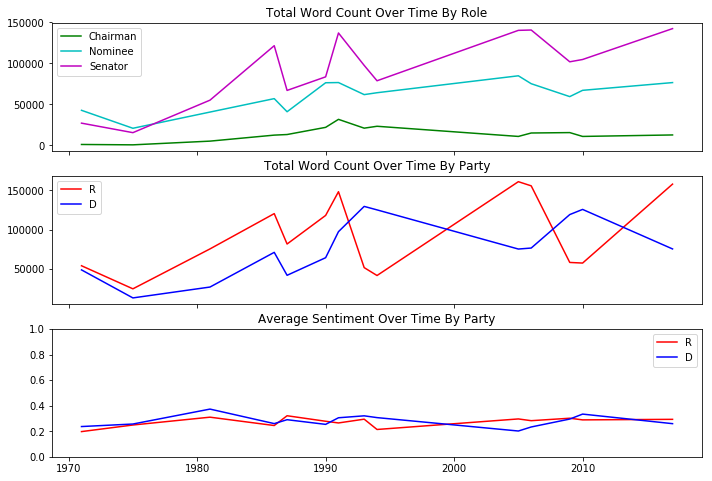

In [29]:
df_word_count_by_role = dataframe[['Year', 'word_count', 'Title']].copy()
word_counts_by_title = df_word_count_by_role.pivot_table(index = 'Year', columns = 'Title', aggfunc = 'sum')
word_counts_by_title.columns = word_counts_by_title.columns.droplevel()
word_counts_by_title.reset_index(inplace = True)

df_word_counts_by_party = dataframe[['Year', 'word_count', 'Party']].copy()
word_counts_by_party = df_word_counts_by_party.pivot_table(index = 'Year', columns = 'Party', aggfunc = 'sum')
word_counts_by_party.columns = word_counts_by_party.columns.droplevel()
word_counts_by_party.reset_index(inplace = True)

df_sentiment_by_party = dataframe[['Year', 'Sentiment', 'Party']].copy()
sentiment_by_party = df_sentiment_by_party.pivot_table(index = 'Year', columns = 'Party', aggfunc = 'mean')
sentiment_by_party.columns = sentiment_by_party.columns.droplevel()
sentiment_by_party.reset_index(inplace = True)

fig, axs = plt.subplots(3,1, sharex = True, figsize = (10,8))
axs[0].plot(word_counts_by_title['Year'], word_counts_by_title['Chairman'], color = 'g')
axs[0].plot(word_counts_by_title['Year'], word_counts_by_title['Nominee'], color = 'c')
axs[0].plot(word_counts_by_title['Year'], word_counts_by_title['Senator'], color = 'm')
axs[0].legend()
axs[0].set_title("Total Word Count Over Time By Role", fontsize = 12)
axs[1].plot(word_counts_by_party['Year'], word_counts_by_party['R'], color = 'r')
axs[1].plot(word_counts_by_party['Year'], word_counts_by_party['D'], color = 'b')
axs[1].legend()
axs[1].set_title("Total Word Count Over Time By Party")
axs[2].plot(sentiment_by_party['Year'], sentiment_by_party['R'], color = 'r')
axs[2].plot(sentiment_by_party['Year'], sentiment_by_party['D'], color = 'b')
axs[2].set_title("Average Sentiment Over Time By Party")
axs[2].set_ylim(0,1)
axs[2].legend()

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)


Text(0.5,1,u'Top Senators by Word Count')

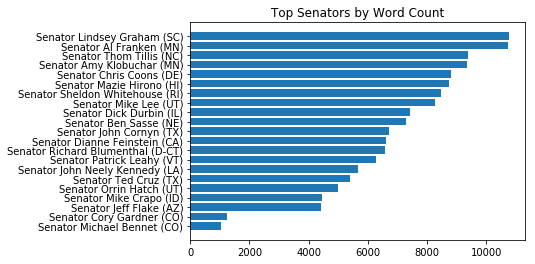

In [42]:
nominee = 'gorsuch' #Insert the supreme court nominee who's hearing you'd like to analyze between the quotes

dataframe['Hearing'] = dataframe['Hearing'].str.lower()
hearing_df = dataframe[dataframe['Hearing'].str.contains(nominee)]
senator_df = hearing_df.loc[hearing_df['Title'] == 'Senator']
senator_df = senator_df[['Speaker', 'word_count']].copy()
senator_grouped = senator_df.groupby(['Speaker']).sum().reset_index()
senator_grouped = senator_grouped.sort_values(by = 'word_count', ascending = True)
s = senator_grouped['Speaker']
c = senator_grouped['word_count']
plt.barh(range(len(s)), c)
plt.yticks(range(len(c)), s)
plt.title('Top Senators by Word Count')

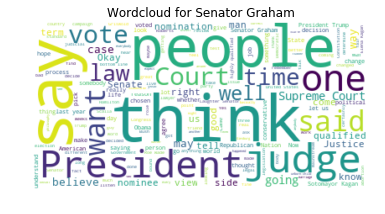

In [78]:
#Select a Senator to analyze. Note that the results will be dependent on the hearing selected in the previous cell.

senator = 'graham' 

senator = senator.lower()
hearing_df['Speaker'] = hearing_df['Speaker'].str.lower()
senator_wc = hearing_df[hearing_df['Speaker'].str.contains(senator)]
senator_wc['Statements'] = map(remove_stopwords, senator_wc['Statements'])
statements = senator_wc['Statements'].tolist()
words = []
for statement in statements:
    tokenized = word_tokenize(statement)
    for word in tokenized:
        words.append(word)
joined = ' '.join(words)

wordcloud = WordCloud(background_color='white').generate(joined)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Wordcloud for Senator " + senator.title())
plt.axis("off")
plt.show()